## Making data

In [1]:
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [4]:
import pandas as pd
circles = pd.DataFrame({'X1':X[:, 0], 'X2':X[:, 1], 'label':y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [5]:
circles['label'].value_counts()

1    500
0    500
Name: label, dtype: int64

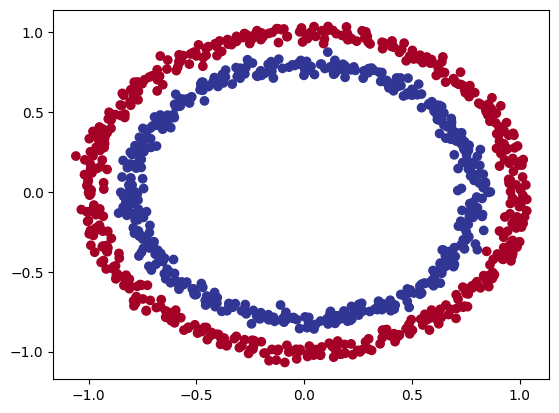

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap='RdYlBu')

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a model

In [10]:
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/balakrishnan/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

In [11]:
class CircleModelV0(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# Equivalently,
model_0_seq = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0_seq
# Always runs in sequential order. Our user-defined subclasses are more flexible

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
untrained_preds = model_0(X_test.to(device))
print(len(untrained_preds), untrained_preds.shape)
print(len(y_test), y_test.shape)
print(untrained_preds[:10])
print(y_test[:10])

200 torch.Size([200, 1])
200 torch.Size([200])
tensor([[ 0.0458],
        [-0.0745],
        [ 0.2853],
        [-0.0218],
        [ 0.1650],
        [ 0.0925],
        [-0.1508],
        [-0.1120],
        [ 0.2900],
        [-0.0839]], grad_fn=<SliceBackward0>)
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [16]:
def accuracy_fn(y_true, y_pred): # metric
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## Training

In [17]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0458],
        [-0.0745],
        [ 0.2853],
        [-0.0218],
        [ 0.1650]], grad_fn=<SliceBackward0>)

In [18]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5114],
        [0.4814],
        [0.5708],
        [0.4946],
        [0.5412]], grad_fn=<SigmoidBackward0>)

In [19]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 0., 1., 0., 1.], grad_fn=<SqueezeBackward0>)

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [21]:
torch.manual_seed(42)
epochs = 100
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69918, Accuracy: 51.88% | Test loss: 0.69184, Test acc: 52.50%
Epoch: 10 | Loss: 0.69745, Accuracy: 50.38% | Test loss: 0.69115, Test acc: 52.50%
Epoch: 20 | Loss: 0.69645, Accuracy: 50.00% | Test loss: 0.69100, Test acc: 52.50%
Epoch: 30 | Loss: 0.69577, Accuracy: 49.62% | Test loss: 0.69105, Test acc: 53.00%
Epoch: 40 | Loss: 0.69527, Accuracy: 49.75% | Test loss: 0.69119, Test acc: 52.00%
Epoch: 50 | Loss: 0.69488, Accuracy: 49.88% | Test loss: 0.69136, Test acc: 51.00%
Epoch: 60 | Loss: 0.69458, Accuracy: 49.88% | Test loss: 0.69156, Test acc: 52.50%
Epoch: 70 | Loss: 0.69433, Accuracy: 50.00% | Test loss: 0.69175, Test acc: 51.00%
Epoch: 80 | Loss: 0.69413, Accuracy: 50.00% | Test loss: 0.69195, Test acc: 51.00%
Epoch: 90 | Loss: 0.69397, Accuracy: 50.00% | Test loss: 0.69214, Test acc: 51.00%


## Predict and evaluate

In [22]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

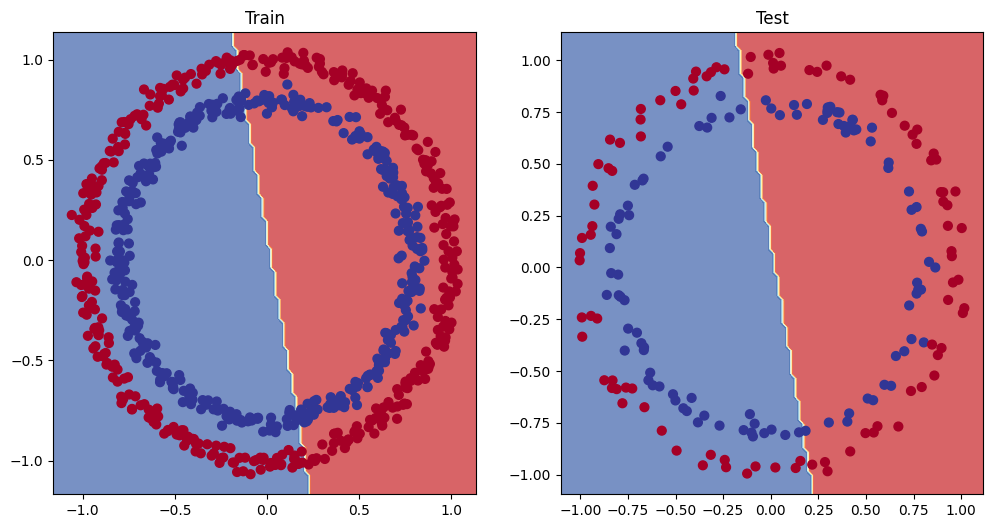

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## "Improving the model"

In [24]:
class CircleModelV1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [26]:
torch.manual_seed(42)
epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test accuracy: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test accuracy: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test accuracy: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test accuracy: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test accuracy: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test accuracy: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test accuracy: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test accuracy: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test accuracy: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test accuracy: 46.00%


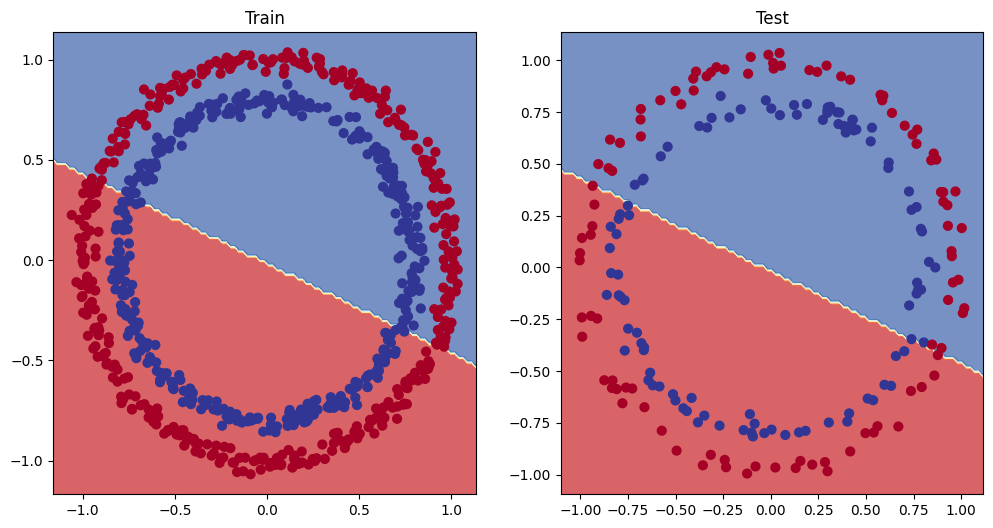

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### Can our model fit at least linear data?

In [29]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [30]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

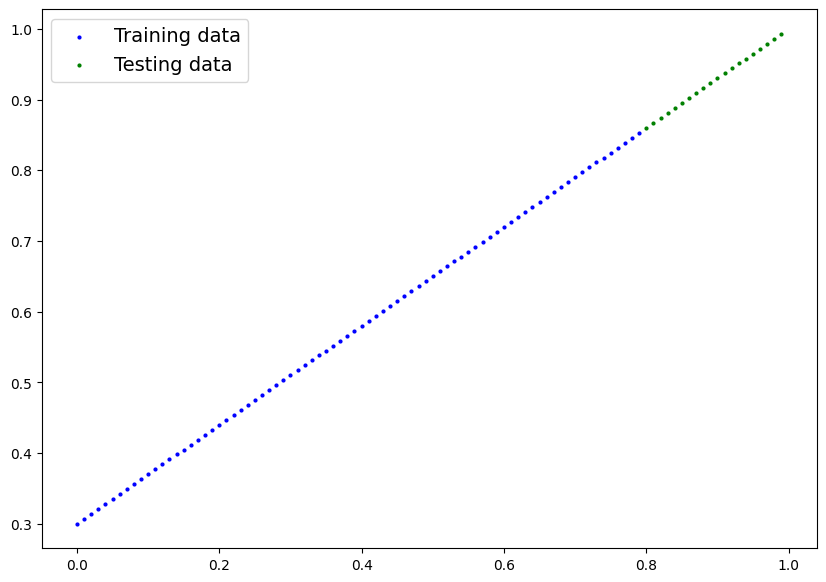

In [31]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

In [32]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [34]:
torch.manual_seed(42)
epochs = 1000
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}')

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05600, Test loss: 0.01425
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


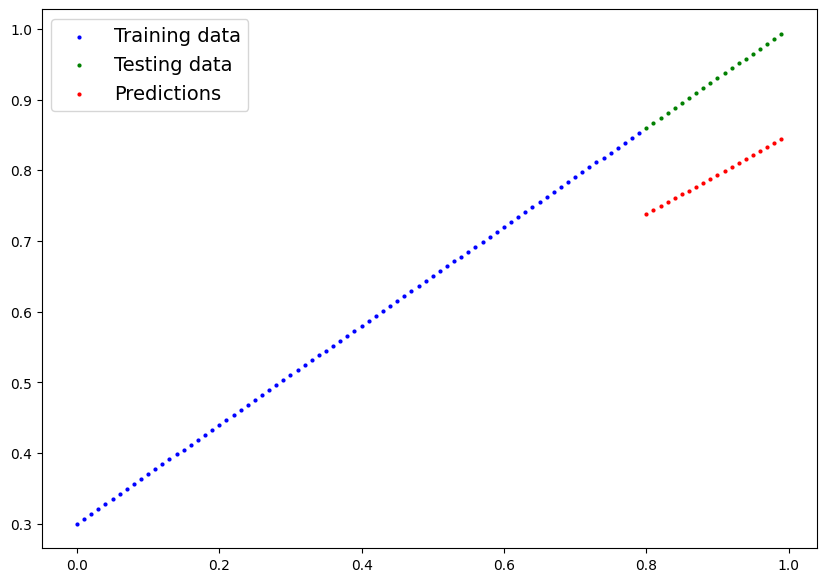

In [35]:
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(X_test_regression)
plot_predictions(
    train_data=X_train_regression.cpu(),
    train_labels=y_train_regression.cpu(),
    test_data=X_test_regression.cpu(),
    test_labels=y_test_regression.cpu(),
    predictions=y_preds.cpu()
)

## Adding non-linearity

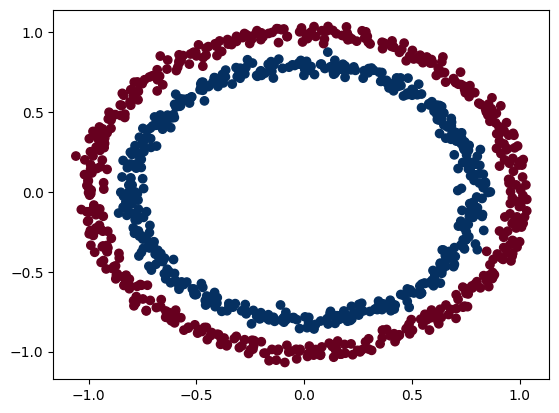

In [36]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu')

In [37]:
from sklearn.model_selection import train_test_split
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [38]:
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer_3(
            self.relu(
                self.layer_2(
                    self.relu(
                        self.layer_1(x)
                    )
                )
            )
        )

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [39]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [40]:
torch.manual_seed(42)
epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()
    y_logits =  model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")
        

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [44]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

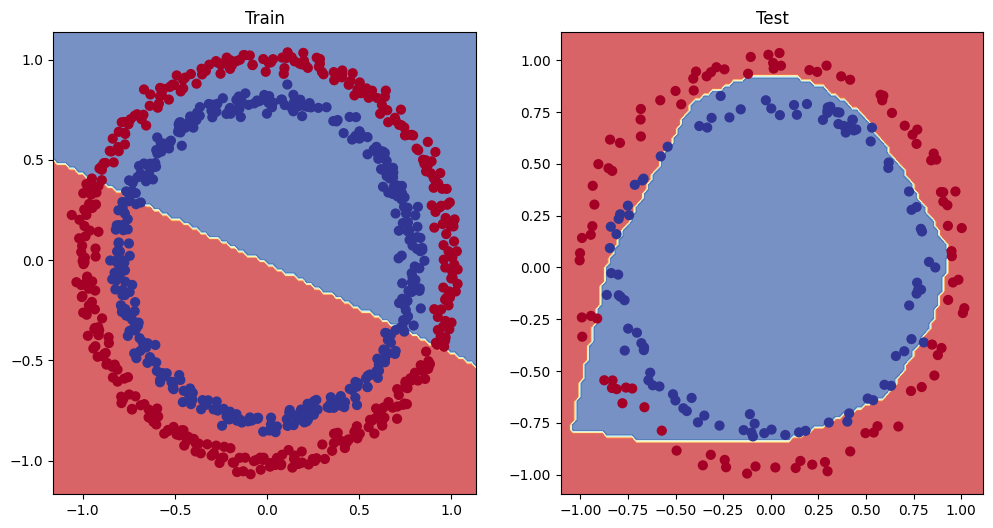

In [45]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## Visualizing non-linear activation functions

In [46]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

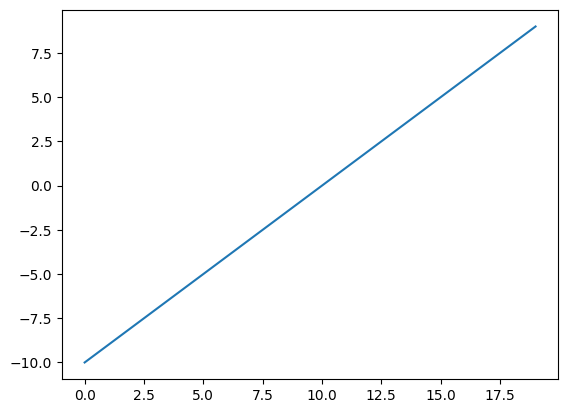

In [47]:
plt.plot(A)

In [48]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

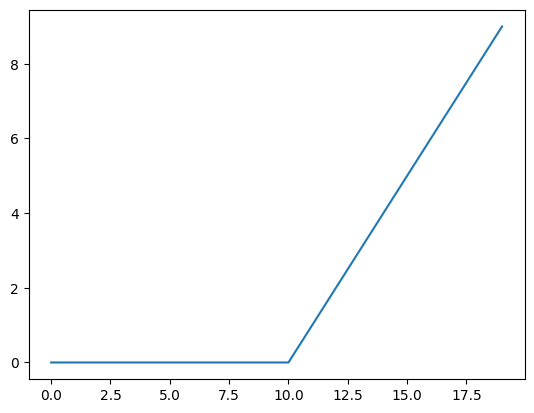

In [49]:
plt.plot(relu(A))

In [50]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

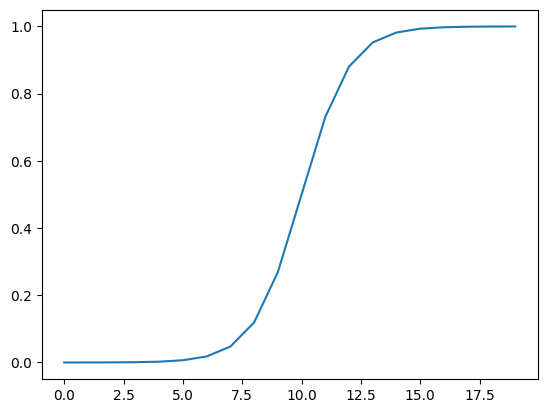

In [51]:
plt.plot(sigmoid(A))

## Putting it together, multi-class

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


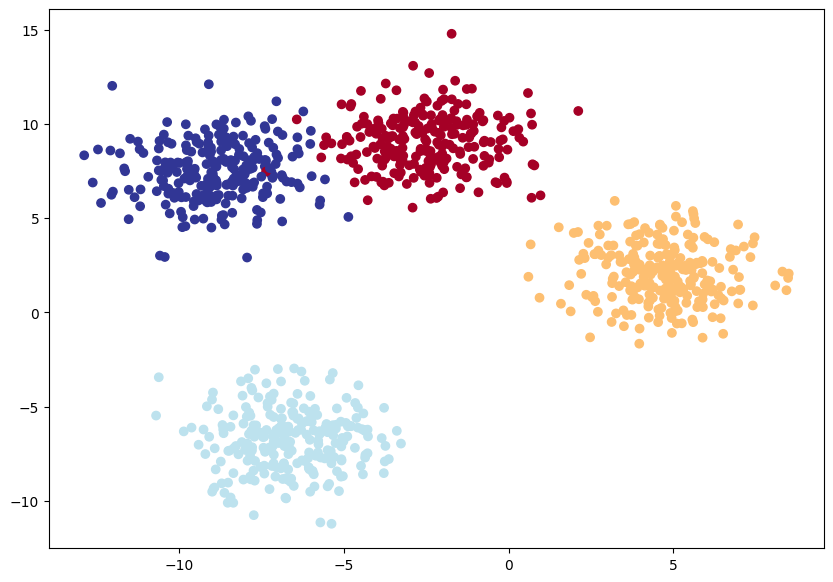

In [52]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    random_state=RANDOM_SEED
)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap='RdYlBu')

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [55]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features:int, output_features:int, hidden_units:int=8) -> None:
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [56]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [57]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [58]:
y_logits = model_4(X_blob_test.to(device))
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)


In [59]:
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [60]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(3)


In [61]:
torch.manual_seed(42)
epochs = 100
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


In [62]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

In [65]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)
print("Predictions:", y_preds[:10])
print("Labels:", y_blob_test[:10])
print(accuracy_fn(y_true=y_blob_test, y_pred=y_preds), '%', sep='')

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
99.5%


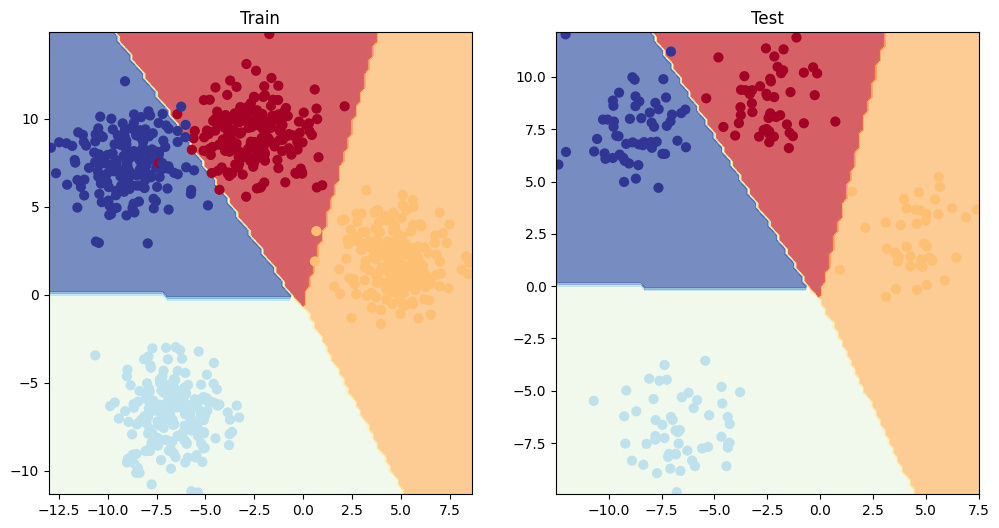

In [66]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)